In [1]:
# imports
from Bio import AlignIO
from Bio.Align.Applications import ClustalwCommandline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [58]:
# variables
project = 'Jamy_2022'
cell = 'cell'
marker = 'rDNA'
sim = 'sim99'
raw_data = '../raw_data'
vamp_spec_dir = f'{raw_data}/vamp_specific_seqs/{project}/{marker}/{cell}/{sim}'
clustalw_path = f'{raw_data}/packages/clustalw-2.1-linux-x86_64-libcppstatic/clustalw2'
pics_dir = f'{raw_data}/OTU_results/{project}'

In [3]:
# functions

def strip(file_path, output_path='out_stripped.fasta'):
    '''
    Remove line breaks in FASTA files
    '''
    seqs = []
    # read a file and stripped it
    with open(file_path,'rt') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith('>'):
                seqs.append('\n' + line)
            else:
                line_cleaned = line.rstrip()
                seqs.append(line_cleaned)
        seqs[0] = seqs[0].lstrip()
    # write the file into fasta
    with open(output_path, 'w') as fp:
        for seq in seqs:
            fp.write(seq)
            
            

def calc_perc_ident(path='out_stripped.fasta'):
    '''
    Calculate percent identity between already-aligned sequences
    '''
    
    data = {}

    # getting sequences into dictionary
    with open(path, 'rt') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith('>'):
                seq_id = line.strip('>consensus=').strip('\n')
            else:
                data[seq_id] = line.strip('\n')
                
    perc_identity = {}
    keys = [key for key in data.keys()]
    
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            perc_identity[keys[i] + '__vs__' + keys[j]] = 0
            for position in range(len(data[keys[i]])):
                if data[keys[i]][position] == data[keys[j]][position]:
                    perc_identity[keys[i] + '__vs__' + keys[j]] += 1

    for k in perc_identity.keys():
        perc_identity[k] = perc_identity[k] / len(data[keys[0]]) * 100
    
    return perc_identity

# Percentage similarity tables

We will create percentage similarity tables to find out how the individual vampyrellids sequences from the long fragment (rDNA operon) are similar to each other.
Based on this information, we can decide if additional OTU clustering is needed and if yes what percentage similarity to use.

## Creating alignments

In [ ]:
# paths
all_files = os.listdir(vamp_spec_dir)
all_paths = [f'{vamp_spec_dir}/{path}' for path in all_files if 'nonrare_otu_' in path]

for path in all_paths:
    sample_id = path.split('_')[-1].split('.')[0]
    # creating an alingnment using clustalw:
    # see more here: https://manpages.ubuntu.com/manpages/impish/man1/clustalw.1.html
    cmd = ClustalwCommandline(clustalw_path,
                              infile=path,
                              output='fasta',
                              outfile=f'{vamp_spec_dir}/aligned_nonrare_otu_{sample_id}.fasta')
    # print clustal command in a linux style
    print(cmd)
    # run clustalw alignment
    stdout, stderr = cmd()

In [ ]:
# if you want to check the resulting alignments using biopython

align = AlignIO.read('path/to/the/alignment', 'fasta')
print(align)

In [ ]:
# Remove line breaks in FASTA files

# paths
all_files = os.listdir(vamp_spec_dir)
all_paths = [f'{vamp_spec_dir}/{path}' for path in all_files if 'aligned_nonrare_otu_' in path]

all_paths

for path in all_paths:
    sample_id = path.split('_')[-1].split('.')[0]
    strip(file_path=path, output_path=f'{vamp_spec_dir}/aligned_stripped_nonrare_otu_{sample_id}.fasta')

## Calculating percentage identity matrix between sequences in the alignment

In [4]:
# paths
all_files = os.listdir(vamp_spec_dir)
all_paths = [f'{vamp_spec_dir}/{path}' for path in all_files if 'aligned_stripped_nonrare_otu_' in path]


perc_identity = {}

# Calculating percentage identity matrix using the custome calc_perc_ident function
for path in all_paths:
    sample_id = path.split('_')[-1].split('.')[0]
    perc_identity[sample_id] = calc_perc_ident(path)

In [5]:
# Samples

perc_identity.keys()

dict_keys(['ERR6454466', 'ERR6454468', 'ERR6454467', 'ERR6454462', 'ERR6454461', 'ERR6454465', 'ERR6454464', 'ERR6454469'])

In [191]:
# Result

perc_identity['ERR6454461'].keys()

dict_keys(['720a1f20551b516c4cf1__vs__0734dd119b2f9616ad7'])

## Visualizing the percentage identity matrix

In [198]:
# Convert data into the right format

sample = 'ERR6454469'


sequences = set()
for key in perc_identity[sample].keys():
    seq1, seq2 = key.split('__vs__')
    sequences.add(seq1)
    sequences.add(seq2)

sequences = list(sequences)  # Convert set to list


df_perc_identity = pd.DataFrame(index=sequences, columns=sequences)
df_perc_identity = df_perc_identity.fillna(100)


for key, value in perc_identity[sample].items():
    seq1, seq2 = key.split('__vs__')
    df_perc_identity.loc[seq1, seq2] = value
    df_perc_identity.loc[seq2, seq1] = value

df_perc_identity

61e84651bc0c6ed78fc74c9eccb4f69b2cfb3768_seqs=16  \
61e84651bc0c6ed78fc74c9eccb4f69b2cfb3768_seqs=16                                        100.000000   
18e900af62ec496746f40ea7cbafd5a49be06ecc_seqs=83                                         98.715891   
3fb4041d645a4a665575ed19c2d58aba044a3a82_seqs=5                                          74.134373   

                                                  18e900af62ec496746f40ea7cbafd5a49be06ecc_seqs=83  \
61e84651bc0c6ed78fc74c9eccb4f69b2cfb3768_seqs=16                                         98.715891   
18e900af62ec496746f40ea7cbafd5a49be06ecc_seqs=83                                        100.000000   
3fb4041d645a4a665575ed19c2d58aba044a3a82_seqs=5                                          73.331805   

                                                  3fb4041d645a4a665575ed19c2d58aba044a3a82_seqs=5  
61e84651bc0c6ed78fc74c9eccb4f69b2cfb3768_seqs=16                                        74.134373  
18e900af62ec496746f40ea7cbafd5a49be06ecc_seqs=83                                        73.331805  
3fb4041d645a4a665575ed19c2d58aba044a3a82_seqs=5                                        100.000000

In [124]:
# Put a line break into middle of the label names as they are too long
labels = []
for label in sequences:
    middle_point = int(len(label) / 2)
    label = label[:middle_point] + '\n' + label[middle_point:]
    labels.append(label)

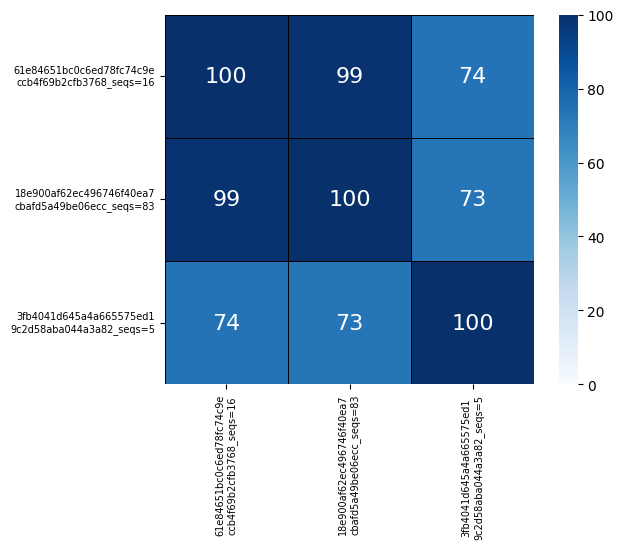

In [126]:
# Heatmap

sns.heatmap(df_perc_identity, 
            vmin = 0,
            vmax = 100,
            cmap = 'Blues', 
            annot = True, 
            fmt = '.0f', 
            annot_kws = {'fontsize': 16}, 
            linewidth = .7,
            linecolor = 'black', 
            square = True,
            xticklabels=labels,
            yticklabels=labels)

plt.tick_params(labelsize=7);

# save
plt.savefig(f"{pics_dir}/percentage_similarity_comparison_heatmap_{sample}.png", 
            dpi=300, 
            transparent=False, 
            facecolor='white', 
            bbox_inches="tight")

## Visualizing the distribution of similarity probabilities

Since the probabilities are continuous, I need create bins or categories to group the similarity ranges. Each bin represents a range of similarity values, and the height of each bin in the histogram will indicate the frequency or count of sequences falling within that similarity range.

### Per sample

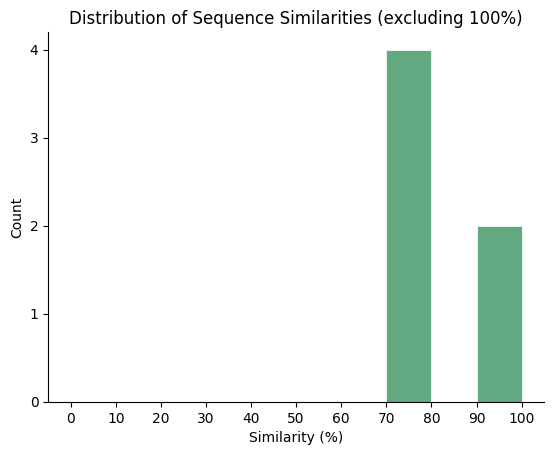

In [199]:
# Filter out rows and columns with 100% similarity
# Set the desire sample in the first cell in 1.3  Visualizing the percentage identity matrix
df_filtered = df_perc_identity[df_perc_identity < 100]

# Flatten the similarity values from the DataFrame into a list
similarity_values = df_filtered.values.flatten()
similarity_values

# Define the bin ranges for the histogram
bin_ranges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create the histogram using Seaborn
sns.histplot(similarity_values, 
             bins = 20, 
             kde = False,  
             edgecolor = 'white',
             linewidth = .5,
             binrange = (0, 100), 
             binwidth = 10,
             color = 'seagreen')

# Customize the plot
plt.xlabel('Similarity (%)')
plt.ylabel('Count')
plt.title('Distribution of Sequence Similarities (excluding 100%)')
plt.locator_params(integer=True)
plt.xticks(bin_ranges)
sns.despine()


# save
plt.savefig(f"{pics_dir}/percentage_similarity_distribution_histplot_{sample}.png", 
            dpi=300, 
            transparent=False, 
            facecolor='white', 
            bbox_inches="tight")

### All samples together

**Dump all the vamp-specific FASTA files into a single FASTA file**

In [207]:
# paths
all_files = os.listdir(vamp_spec_dir)
all_paths = [f'{vamp_spec_dir}/{path}' for path in all_files if path.startswith('nonrare_otu_') and path.endswith('.fasta')]


# dump all the vamp-specific FASTA files into a single FASTA file
with open(f'{vamp_spec_dir}/nonrare_otu_all_samples.fasta', 'w') as outfile:
    for path in all_paths:
        with open(path) as infile:
            for line in infile:
                outfile.write(line)

**Remove line breaks in FASTA files**

In [209]:
path = f'{vamp_spec_dir}/nonrare_otu_all_samples.fasta'

strip(path, output_path = path)

**Create an alingnment using clustalw**

In [210]:
# clustalw alignment

path = f'{vamp_spec_dir}/nonrare_otu_all_samples.fasta'
sample_id = 'all_samples'

# creating an alingnment using clustalw:
# see more here: https://manpages.ubuntu.com/manpages/impish/man1/clustalw.1.html
cmd = ClustalwCommandline(clustalw_path,
                          infile=path,
                          output='fasta',
                          outfile=f'{vamp_spec_dir}/aligned_nonrare_otu_{sample_id}.fasta')
# print clustal command in a linux style
print(cmd)
# run clustalw alignment
stdout, stderr = cmd()

../raw_data/packages/clustalw-2.1-linux-x86_64-libcppstatic/clustalw2 -infile=../raw_data/vamp_specific_seqs/Jamy_2022/rDNA/cell/sim99/nonrare_otu_all_samples.fasta -outfile=../raw_data/vamp_specific_seqs/Jamy_2022/rDNA/cell/sim99/aligned_nonrare_otu_all_samples.fasta -output=fasta


**Remove line breaks in FASTA files**

In [211]:
# strip

path = f'{vamp_spec_dir}/aligned_nonrare_otu_all_samples.fasta'

strip(path, output_path = path)

**Calculating percentage identity matrix using the *custome calc_perc_ident* function**

In [212]:
perc_identity = {}
path = f'{vamp_spec_dir}/aligned_nonrare_otu_all_samples.fasta'

# Calculating percentage identity matrix using the custome calc_perc_ident function

sample_id = 'all_samples'
perc_identity[sample_id] = calc_perc_ident(path)

**Converting data into the right format**

In [213]:
# Convert data into the right format

sample = 'all_samples'


sequences = set()
for key in perc_identity[sample].keys():
    seq1, seq2 = key.split('__vs__')
    sequences.add(seq1)
    sequences.add(seq2)

sequences = list(sequences)  # Convert set to list


df_perc_identity = pd.DataFrame(index=sequences, columns=sequences)
df_perc_identity = df_perc_identity.fillna(100)


for key, value in perc_identity[sample].items():
    seq1, seq2 = key.split('__vs__')
    df_perc_identity.loc[seq1, seq2] = value
    df_perc_identity.loc[seq2, seq1] = value

df_perc_identity

dfd0ac97c937124602dd8b5fb0751962a7bd562b_seqs=10  \
dfd0ac97c937124602dd8b5fb0751962a7bd562b_seqs=10                                        100.000000   
3d2c349752f7c6795d3d66064db6644ce7c0d95f_seqs=13                                         71.035919   
1c21b0efcc08c50a44f6c62bc88111de33b49740_seqs=14                                         72.878709   
f22df12fa83f928a12c1bbed6b410739280f03fe_seqs=2                                          73.732431   
7ea04525b3c5f3001e48e6c0a2a5ba1d12304bda_seqs=6                                          73.170224   
...                                                                                            ...   
3f4709c3e883070369f801ed383c660678af2dfb_seqs=12                                         72.170744   
372051f9b76ab3adebc84300d002e149dc5d422e_seqs=11                                         81.457574   
5c16a094510acd43457831c0e1643c490dae507e_seqs=24                                         72.451848   
19aa5d9c8fcf6b4ad69f48b41fc5bfe634b673ad_seqs=24                                         73.211869   
2d31d2056dbb83c8865abe63aab33fcbb5cf9ad_seqs=325                                         73.211869   

                                                  3d2c349752f7c6795d3d66064db6644ce7c0d95f_seqs=13  \
dfd0ac97c937124602dd8b5fb0751962a7bd562b_seqs=10                                         71.035919   
3d2c349752f7c6795d3d66064db6644ce7c0d95f_seqs=13                                        100.000000   
1c21b0efcc08c50a44f6c62bc88111de33b49740_seqs=14                                         91.525247   
f22df12fa83f928a12c1bbed6b410739280f03fe_seqs=2                                          81.384695   
7ea04525b3c5f3001e48e6c0a2a5ba1d12304bda_seqs=6                                          83.675169   
...                                                                                            ...   
3f4709c3e883070369f801ed383c660678af2dfb_seqs=12                                         86.861010   
372051f9b76ab3adebc84300d002e149dc5d422e_seqs=11                                         74.679854   
5c16a094510acd43457831c0e1643c490dae507e_seqs=24                                         87.152525   
19aa5d9c8fcf6b4ad69f48b41fc5bfe634b673ad_seqs=24                                         94.263404   
2d31d2056dbb83c8865abe63aab33fcbb5cf9ad_seqs=325                                         94.273816   

                                                  1c21b0efcc08c50a44f6c62bc88111de33b49740_seqs=14  \
dfd0ac97c937124602dd8b5fb0751962a7bd562b_seqs=10                                         72.878709   
3d2c349752f7c6795d3d66064db6644ce7c0d95f_seqs=13                                         91.525247   
1c21b0efcc08c50a44f6c62bc88111de33b49740_seqs=14                                        100.000000   
f22df12fa83f928a12c1bbed6b410739280f03fe_seqs=2                                          84.216554   
7ea04525b3c5f3001e48e6c0a2a5ba1d12304bda_seqs=6                                          85.580427   
...                                                                                            ...   
3f4709c3e883070369f801ed383c660678af2dfb_seqs=12                                         89.619990   
372051f9b76ab3adebc84300d002e149dc5d422e_seqs=11                                         76.814159   
5c16a094510acd43457831c0e1643c490dae507e_seqs=24                                         89.734513   
19aa5d9c8fcf6b4ad69f48b41fc5bfe634b673ad_seqs=24                                         95.262884   
2d31d2056dbb83c8865abe63aab33fcbb5cf9ad_seqs=325                                         95.273295   

                                                  f22df12fa83f928a12c1bbed6b410739280f03fe_seqs=2  \
dfd0ac97c937124602dd8b5fb0751962a7bd562b_seqs=10                                        73.732431   
3d2c349752f7c6795d3d66064db6644ce7c0d95f_seqs=13                                        81.384695   
1c21b0efcc08c50a44f6c62bc88111de33b49740_seqs=14                        

**Visualizing the distribution of similarity probabilities**

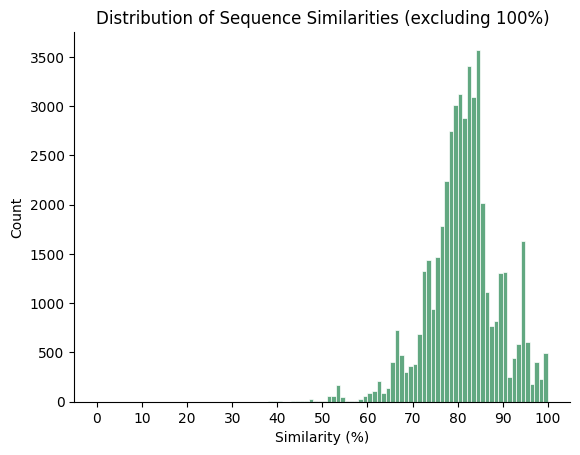

In [216]:
# Filter out rows and columns with 100% similarity
# Set the desire sample in the first cell in 1.3  Visualizing the percentage identity matrix
df_filtered = df_perc_identity[df_perc_identity < 100]

# Flatten the similarity values from the DataFrame into a list
similarity_values = df_filtered.values.flatten()
similarity_values

# Define the bin ranges for the histogram
bin_ranges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create the histogram using Seaborn
sns.histplot(similarity_values, 
             bins = 100, 
             kde = False,  
             edgecolor = 'white',
             linewidth = .5,
             binrange = (0, 100), 
#              binwidth = 10,
             color = 'seagreen')

# Customize the plot
plt.xlabel('Similarity (%)')
plt.ylabel('Count')
plt.title('Distribution of Sequence Similarities (excluding 100%)')
plt.locator_params(integer=True)
plt.xticks(bin_ranges)
sns.despine()


# save
plt.savefig(f"{pics_dir}/percentage_similarity_distribution_histplot_{sample}.png", 
            dpi=300, 
            transparent=False, 
            facecolor='white', 
            bbox_inches="tight")